<a href="https://colab.research.google.com/github/juliabui/csc408-411/blob/main/CSC408Mod3LogLossTuningActivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tuning Log Loss

##Goal

You will practice tuning a Logistic Regression model using log loss as the optimization metric. This emphasizes the quality of predicted probabilities, not just classification accuracy.

##Step 1. Load and split the data

* Use the built-in breast_cancer dataset (already in the code).

* The dataset is automatically split into training (80%) and test (20%).

* Stratification keeps the proportion of classes balanced in both sets.

* Why? → Prevents data leakage and ensures test data is untouched until the very end.

##Step 2. Build the pipeline

* A pipeline ensures preprocessing (StandardScaler) happens inside each CV fold, avoiding leakage.

* Logistic Regression is wrapped in the pipeline.

* For simplicity, start with L2 penalty only.

## Step 3. Define the hyperparameter grid

The hyperparameter of interest is C:

* Smaller C → stronger regularization → simpler model, less overconfident.

* Larger C → weaker regularization → more complex model, risk of overfitting.

* Start with:

`C_grid = np.logspace(-3, 3, 13)`

  which means: 0.001, 0.002, …, 1000 (logarithmic spacing).

  * Your job: Adjust this grid if you want to zoom in/out.

  Example: `np.logspace(-4, 4, 17)` for a wider search.

##Step 4. Run cross-validation with GridSearchCV

* 5-fold stratified CV is used for fair comparison.

* Scoring is `neg_log_loss` (the smaller the better).

* GridSearch finds the best C based on log loss.

You don’t change anything here.

## Step 5. Inspect results

The script prints:

* A small table of candidate C values with mean/standard deviation of CV log loss.

* The best C and its CV log loss.

Optional: Look at the validation curve plot (C vs. log loss).

* Expect a “U-shaped” or “flattening” curve.

## Step 6. Evaluate once on the test set

* The best model (already refit on the full training data) is evaluated once.

* Report these metrics:

  * Log loss (main optimization target).

  * ROC AUC (ranking quality of probabilities).

  * Accuracy at threshold 0.5.


###Tips

* Remember: smaller `C` = **stronger regularization** (shrinks extreme weights, reduces overconfidence).

* Keep the pipeline - **no leakage.**

* Report **both:** the optimized **log loss** and a **ranking metric** (ROC AUC).

* Test **once** at the end.


Best params (by CV log loss):
{'logisticregression__C': np.float64(1.0),
 'logisticregression__class_weight': None,
 'logisticregression__penalty': 'l2'}
Best CV log loss: 0.0711


,rank_test_neg_log_loss,cv_log_loss,cv_log_loss_std,cv_auc,param_logisticregression__penalty,param_logisticregression__C,param_logisticregression__class_weight
24,1,0.071148,0.027461,0.995975,l2,1.000000,None
26,2,0.075357,0.024089,0.995769,l2,1.000000,balanced
20,3,0.078234,0.022806,0.995562,l2,0.316228,None
27,4,0.080636,0.020782,0.995562,l1,1.000000,balanced
22,5,0.080959,0.019421,0.995562,l2,0.316228,balanced
25,6,0.082401,0.023105,0.994530,l1,1.000000,None
28,7,0.082862,0.042161,0.994427,l2,3.162278,None
29,8,0.087534,0.045317,0.994634,l1,3.162278,None
30,9,0.090986,0.041104,0.994221,l2,3.162278,balanced
21,10,0.095106,0.015906,0.994221,l1,0.316228,None


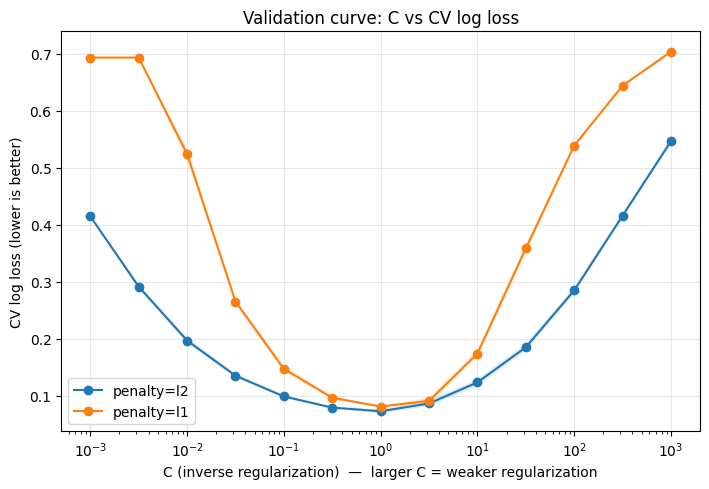


=== Final test metrics (evaluate once) ===
Log loss:        0.0781
ROC AUC:         0.9957
Brier score:     0.0217
Accuracy @0.5:   0.9825

Notes:
• If curves flatten and don’t change much with C, the model may be capacity-limited;
  feature engineering or a different model could help more than more tuning.
• 'balanced' class_weight helps when classes are imbalanced; accept a small log-loss change if ROC AUC improves.


In [ ]:
# ============================================
# Log-loss tuning for Logistic Regression (binary)
# ============================================

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pprint import pprint

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    log_loss, roc_auc_score, brier_score_loss, accuracy_score
)

RNG = 42

# ---------- 1) Data ----------
data = load_breast_cancer(as_frame=True)
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RNG
)

# ---------- 2) Pipeline (leakage-safe) ----------
pipe = make_pipeline(
    StandardScaler(),                             # fit on CV-train folds only
    LogisticRegression(max_iter=3000, solver="liblinear")  # L1/L2 supported
)

# ---------- 3) Hyperparameter grid (STUDENTS TUNE THIS) ----------
# Tip: widen first (1e-4..1e3), then narrow around the best; densify points if needed.
#np.logspace(start exponent, end exponent, points)
#This means a start exponent of -3 = 10^-3 and end exponent of 3 = 10^3
#13 points --> exponents are spaced by 0.5 (-3, -2.5, -2, ..., 2.5, 3)
#this is the sweep of C from a very strong regularization (small C) to very weak (large C)
#Adjust the three numbers to change the lower bound, upper bound, and grid density

C_grid = np.logspace(-3, 3, 13)  # <-- TRY: np.logspace(-4, 4, 17) then zoom in

# Tip: If classes are roughly balanced, you can get rid of "balanced" to reduce search size
# For probability quality, L2 usually calibrates better than very sparse L1, still worth testing though

param_grid = {
    "logisticregression__penalty": ["l2", "l1"],
    "logisticregression__C": C_grid,
    "logisticregression__class_weight": [None, "balanced"],  # optional: helps on imbalance
}


# ---------- 4) Grid search optimizing log loss ----------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring={"neg_log_loss": "neg_log_loss", "roc_auc": "roc_auc"},
    refit="neg_log_loss",   # the one we optimize/tie-break with
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    verbose=0,
)
grid.fit(X_train, y_train)

print("\nBest params (by CV log loss):")
pprint(grid.best_params_)
print(f"Best CV log loss: {-grid.best_score_:.4f}")

# ---------- 5) CV summary table (top 10 by log loss) ----------
res = pd.DataFrame(grid.cv_results_)
res["cv_log_loss"] = -res["mean_test_neg_log_loss"]
res["cv_log_loss_std"] = res["std_test_neg_log_loss"]
res["cv_auc"] = res["mean_test_roc_auc"]
cols = [
    "rank_test_neg_log_loss",
    "cv_log_loss", "cv_log_loss_std", "cv_auc",
    "param_logisticregression__penalty",
    "param_logisticregression__C",
    "param_logisticregression__class_weight",
]
display(res[cols].sort_values("rank_test_neg_log_loss").head(10))

# ---------- 6) Validation curve: C vs log loss (per penalty) ----------
plt.figure(figsize=(7.2, 5.0))
for pen in ["l2", "l1"]:
    sub = res[res["param_logisticregression__penalty"] == pen]
    # it’s a grid over C and class_weight; average over class_weight for a smoother line
    agg = sub.groupby("param_logisticregression__C").agg(
        mean_ll=("cv_log_loss","mean"),
        std_ll=("cv_log_loss","std")
    ).reset_index()
    Cvals = agg["param_logisticregression__C"].values.astype(float)
    plt.plot(Cvals, agg["mean_ll"], marker="o", label=f"penalty={pen}")
    plt.fill_between(Cvals,
                     agg["mean_ll"]-agg["std_ll"],
                     agg["mean_ll"]+agg["std_ll"],
                     alpha=0.15)

plt.xscale("log")
plt.xlabel("C (inverse regularization)  —  larger C = weaker regularization")
plt.ylabel("CV log loss (lower is better)")
plt.title("Validation curve: C vs CV log loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 7) Test once (refit best on full train) ----------
best_pipe = grid.best_estimator_
best_pipe.fit(X_train, y_train)                 # refit on all training data

p_test = best_pipe.predict_proba(X_test)[:, 1]
print("\n=== Final test metrics (evaluate once) ===")
print(f"Log loss:        {log_loss(y_test, p_test):.4f}")
print(f"ROC AUC:         {roc_auc_score(y_test, p_test):.4f}")
print(f"Brier score:     {brier_score_loss(y_test, p_test):.4f}")
print(f"Accuracy @0.5:   {accuracy_score(y_test, p_test >= 0.5):.4f}")

# ---------- 8) Quick interpretation helper ----------
print("\nNotes:")
print("• If curves flatten and don’t change much with C, the model may be capacity-limited;")
print("  feature engineering or a different model could help more than more tuning.")
print("• 'balanced' class_weight helps when classes are imbalanced; accept a small log-loss change if ROC AUC improves.")


#Questions

1. How does `C` affect CV log loss? Where's the sweet spot?




*Answer here*

2. Does `penalty='l1'` ever win? When and why?


*Answer here*

3. What happens with `class_weight='balanced'`?



*Answer here*

4. Compare best CV log loss to test log loss. Are they consistent?



*Answer here*

5. Why optimize log loss instead of accuracy during tuning?


*Answer here*

6. (Stretch) Narrow the grid around the best `C` and rerun. Does the estimate stabilize?



*Answer here*